In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from cloud_colocations.colocations.products import gpm_1c_r, gpm_2a_gprofgmi, \
    gpm_2b_cmb, set_cache
set_cache("../../cache")

Using login:  juliakukulies Strolchi1!


In [2]:
t = datetime(2017, 10, 7, 22, 58, 0)
f = gpm_2a_gprofgmi.get_file_by_date(t)
f = gpm_2a_gprofgmi.download_file(f)

## Input data

Input data for the GPM retrievals is taken from the 1C-r product which includes
all brightness temperatures remapped to common footprints.

In [3]:
import h5py
f = gpm_1c_r.get_file_by_date(t)
f = gpm_1c_r.download_file(f)
f = h5py.File(f, "r")
lats = f["S1"]["Latitude"]
lons = f["S1"]["Longitude"]
i_start = lons.shape[0] // 4 - 100
i_end = lons.shape[0] // 4 + 100

bts_1 = f["S1"]["Tc"][i_start : i_end, :, :]
bts_2 = f["S2"]["Tc"][i_start : i_end, :, :]

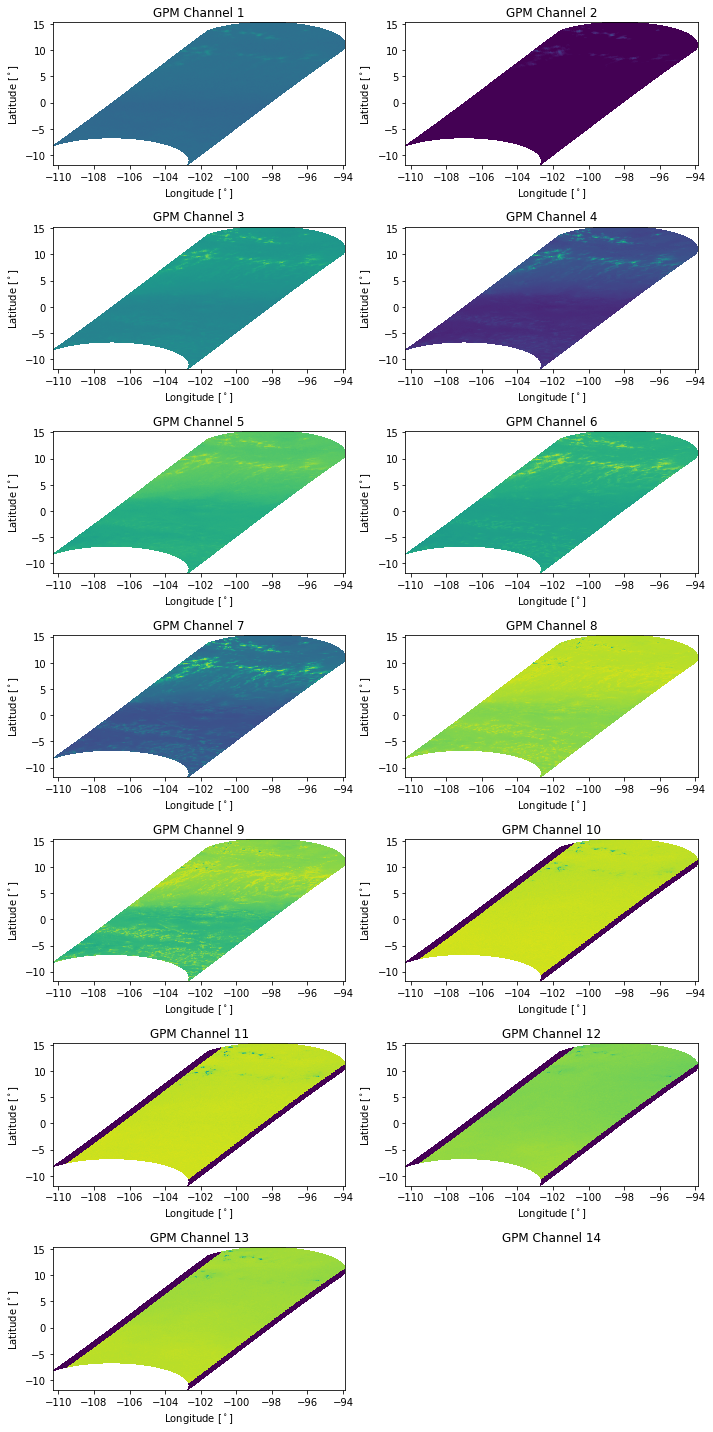

In [4]:
from matplotlib.colors import Normalize

x = lons[i_start : i_end, :]
y = lats[i_start : i_end, :]
f, axs = plt.subplots(7, 2, figsize = (10, 20))
norm = Normalize(100, 300)
axs = axs.ravel()
for i in range(14):
        
    ax = axs[i]
    ax.set_ylabel("Latitude [$^\circ$]")
    ax.set_xlabel("Longitude [$^\circ$]")
    ax.set_title("GPM Channel {}".format(i + 1))
        
    if i < 9:
        ax.pcolormesh(x, y, bts_1[:, :, i], norm = norm)
        
    elif i < 13:
        axs[i].pcolormesh(x, y, bts_2[:, :, i - 9], norm = norm)
    else:
        axs[i].set_axis_off()
plt.tight_layout()

## Auxiliary data

Auxiliary data is taken from the GPM 2A GPROF-GMI product.

In [5]:
f = gpm_2a_gprofgmi.get_file_by_date(t)
f = gpm_2a_gprofgmi.download_file(f)
f = h5py.File(f, "r")
f["S1"].keys()

<KeysViewHDF5 ['ScanTime', 'SCstatus', 'Latitude', 'Longitude', 'pixelStatus', 'qualityFlag', 'L1CqualityFlag', 'surfaceTypeIndex', 'totalColumnWaterVaporIndex', 'CAPE', 'temp2mIndex', 'sunGlintAngle', 'probabilityOfPrecip', 'spare2', 'surfacePrecipitation', 'frozenPrecipitation', 'convectivePrecipitation', 'rainWaterPath', 'cloudWaterPath', 'iceWaterPath', 'mostLikelyPrecipitation', 'precip1stTertial', 'precip2ndTertial', 'profileTemp2mIndex', 'profileNumber', 'profileScale']>

In [6]:
lat = f["S1"]['Latitude']
lon = f["S1"]['Longitude']
st = f["S1"]['surfaceTypeIndex'][:]
cw = f["S1"]['totalColumnWaterVaporIndex'][:]

## Ground truth

Ground truth is taken from the 2B combined product. 

In [7]:
f = gpm_2b_cmb.get_file_by_date(t)
f

'2B.GPM.DPRGMI.CORRA2018.20171007-S222543-E235817.020509.V06A.HDF5'

In [8]:
f = gpm_2b_cmb.get_file_by_date(t)
f = gpm_2b_cmb.download_file(f)
f = h5py.File(f, "r")
f["MS"].keys()

st_h = f["MS"]["ScanTime"]["Hour"][:]
st_m = f["MS"]["ScanTime"]["Minute"][:]
st_s = f["MS"]["ScanTime"]["Second"][:]

inds = np.where(np.logical_and(st_h == 22,
                               st_m == 57))[0]
i_start = inds[0]
i_end = inds[-1]

pwc = f["NS"]["precipTotWaterCont"][i_start : i_end, :, :]
lwc = f["NS"]["cloudLiqWaterCont"][i_start : i_end, :, :]
iwc = f["NS"]["cloudIceWaterCont"][i_start : i_end, :, :]
sp = f["NS"]["surfPrecipTotRate"][i_start : i_end, :]
x = f["NS"]["Longitude"][i_start : i_end, :]
y = f["NS"]["Latitude"][i_start : i_end, :]

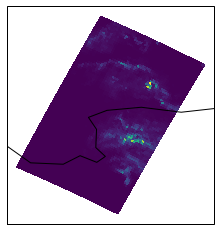

In [9]:
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(x, y, sp)
ax.coastlines()

# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('coastlines.pdf')
plt.savefig('coastlines.png')

plt.show()

In [10]:
from itkwidgets import view
import scipy as sp
import scipy.signal
import itkwidgets
pwc_c = sp.signal(pwc, )
q = np.log10(np.maximum(pwc, 1e-10))
view(q, shadow = False)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…

In [11]:
from cloud_colocations.colocations.formats import GPM

In [12]:
gpm = GPM.get_by_date(t)

In [16]:
gpm.gmi_file.lon_s1
st_h = gpm.gmi_file.file_handle["S1"]["ScanTime"]["Hour"][:]
st_m = gpm.gmi_file.file_handle["S1"]["ScanTime"]["Minute"][:]
st_s = gpm.gmi_file.file_handle["S1"]["ScanTime"]["Second"][:]

inds = np.where(np.logical_and(st_h == 22,
                               st_m == 57))[0]
i_start = inds[0]
i_end = inds[-1]

In [26]:
q.shape

(31, 121, 20)

In [17]:
pwc = gpm.pwc_r[i_start : i_end, 100:, :]
q = np.log10(np.maximum(pwc, 1e-10))
view(q, shadow = False)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageD3; proxy o…

In [25]:
from itkwidgets import view
import scipy as sp
import scipy.signal
import itkwidgets
pwc_c = sp.signal.convolve(pwc, gpm.k3, "valid")
q = np.log10(np.maximum(pwc, 1e-10))
view(q, shadow = False)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageD3; proxy o…

In [21]:
gpm.k3.shape

(9, 9, 9)

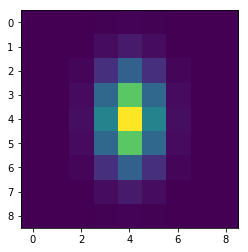

In [23]:
plt.imshow(GPM.kernel)